## BOTTOM LIMITS ARE WRONG - I'VE NOT USED THE PROPER DISTRIBUTIONS FOR ALTERNATIVE TEST STATISTICS, INSTEAD I USED A CHI2

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import scipy.stats       as stats
import pickle

from matplotlib.lines   import Line2D
from matplotlib.patches import Patch

import helpers.model as model
model.setup_defaults()

toys = model.generate_toys(5000)

In [2]:
def save_to_pickle (fname, obj, **kwargs) :
    to_save = [{}, None]
    for k, arg in kwargs.items() :
        to_save[0] [k] = arg
    to_save[1] = obj
    pickle.dump(to_save, open(fname, "wb+"))

def load_from_pickle (fname, **kwargs) :
    from_file = pickle.load(open(fname, "rb"))
    for k, arg in kwargs.items() :
        if k not in from_file[0]   : return None
        if from_file[0] [k] != arg : return None
    return from_file [1]

In [3]:
from enum import Enum, unique, auto

@unique
class TestStatEnum (Enum) :
    NONE              = 0
    TNLL              = auto()
    POSITIVE_SIGNAL   = auto()
    UPPER_LIMIT_TYPE1 = auto()
    UPPER_LIMIT_TYPE2 = auto()

def describe (test_stat_enum) :
    if test_stat_enum is NONE :
        return "No test statistic selected."
    if test_stat_enum is TNLL :
        return "-2log(L_mu/L_best). This asymptotically follows a chi^2 assuming mu is true, and certain regularity conditions are met."
    if test_stat_enum is POSITIVE_SIGNAL :
        return "-2log(L_mu/L_best) but only allows mu_best to be positive, otherwise it is set to 0."
    if test_stat_enum is UPPER_LIMIT_TYPE1 :
        return "-2log(L_mu/L_best) unless mu_best > mu, in which case this is considered consistent with the mu hypothesis and so we set it to 0."
    if test_stat_enum is UPPER_LIMIT_TYPE2 :
        return "-2log(L_mu/L_best) unless mu_best > mu (considered consistent with the mu hypothesis and set to 0), or mu_best < 0 (considered impossible and we enforce mu_best=0)."
    return "Unknown enum."


In [4]:
class TestStat :
    def __init__ (self, dataset=None) :
        self.dataset = dataset
        if dataset is not None :
            self.generate()
    def generate (self, dataset=None) :
        if dataset is None :
            dataset = self.dataset
        if dataset is None :
            raise ValueError("No dataset argument provided and no self.dataset set.")
        self.mu_best, self.f_best = self._get_f_best(dataset)
    def evaluate (self, s, dataset=None) :
        if dataset is None :
            dataset = self.dataset
        if dataset is None :
            raise ValueError("No dataset argument provided and no self.dataset set.")
        return self._get_q(s, dataset)
    @classmethod
    def create(cls, enum, dataset=None) :
        if enum == None              : return TestStat                (dataset)
        if enum == TNLL              : return TestStat_TNLL           (dataset)
        if enum == POSITIVE_SIGNAL   : return TestStat_PositiveSignal (dataset)
        if enum == UPPER_LIMIT_TYPE1 : return TestStat_UpperLimit1    (dataset)
        if enum == UPPER_LIMIT_TYPE2 : return TestStat_UpperLimit2    (dataset)

In [5]:
class TestStat_TNLL (TestStat) :
    def __init__ (self, dataset=None) :
        super(TestStat_TNLL, self).__init__(dataset)
    def _get_f_best (self, dataset) :
        fit = model.do_fit(dataset, fix_s=False, do_minos=False)
        return fit.values['s'], fit.get_fmin().fval
    def _get_q (self, s, dataset) :
        fit = model.do_fit(dataset, s=s, fix_s=True, do_minos=False)
        return fit.get_fmin().fval - self.f_best

In [6]:
class TestStat_PositiveSignal (TestStat) :
    def __init__ (self, dataset=None) :
        super(TestStat_PositiveSignal, self).__init__(dataset)
    def _get_f_best (self, dataset) :
        fit = model.do_fit(dataset, fix_s=False, do_minos=False)
        mu_best = fit.values['s']
        if mu_best < 0 :
            fit = model.do_fit(dataset, s=0, fix_s=True, do_minos=False)
        return fit.values['s'], fit.get_fmin().fval
    def _get_q (self, s, dataset) :
        fit = model.do_fit(dataset, s=s, fix_s=True, do_minos=False)
        return fit.get_fmin().fval - self.f_best

In [7]:
class TestStat_UpperLimit1 (TestStat) :
    def __init__ (self, dataset=None) :
        super(TestStat_UpperLimit1, self).__init__(dataset)
    def _get_f_best (self, dataset) :
        fit = model.do_fit(dataset, fix_s=False, do_minos=False)
        return fit.values['s'], fit.get_fmin().fval
    def _get_q (self, s, dataset) :
        if s < self.mu_best :
            return 0
        fit = model.do_fit(dataset, s=s, fix_s=True, do_minos=False)
        return fit.get_fmin().fval - self.f_best

In [8]:
class TestStat_UpperLimit2 (TestStat) :
    def __init__ (self, dataset=None) :
        super(TestStat_UpperLimit2, self).__init__(dataset)
    def _get_f_best (self, dataset) :
        fit = model.do_fit(dataset, fix_s=False, do_minos=False)
        mu_best = fit.values['s']
        if mu_best < 0 :
            fit = model.do_fit(dataset, s=0, fix_s=True, do_minos=False)
        return fit.values['s'], fit.get_fmin().fval
    def _get_q (self, s, dataset) :
        if s < self.mu_best :
            return 0
        fit = model.do_fit(dataset, s=s, fix_s=True, do_minos=False)
        return fit.get_fmin().fval - self.f_best

### The likelihood ratio

---

- $\lambda\left(\mu\right) = \frac{L\left(\mu, \hat{\hat\theta}\right)}{L\left(\hat\mu, \hat\theta\right)}$

---

- $t_\mu = -2\ln\lambda\left(\mu\right)$

---

- $t_\mu$ is asymptotically expected to follow a $\chi^2$ distribution under the hypothesis of $\mu$. This is Wilks' theorem. We can therefore profile $\mu$ and evaluate the $p$-value at every point.

---

- A frequentist probability of X% at a hypothesised $\mu$ means that, if that $\mu$ were true, we expect X% of experiments to result in the $t_\mu$ which was measured. But $\rho\left(t_\mu\right) \sim \chi^2$. So $\rho\left(\mu\right) = \rho\left(t_\mu\right) \sim \chi^2$, and we are really 

---

In [9]:
mu_best_TNLL, mu_best_PosSig, mu_best_UppLim1, mu_best_UppLim2 = [], [], [], []
q_TNLL, q_PosSig, q_UppLim1, q_UppLim2 = [], [], [], []

for idx_toy, toy in enumerate(toys) :
    if (1+idx_toy)*10 % len(toys) == 0 :
        print(f"{100*(1+idx_toy)/len(toys):.0f}% complete")
    test_stat_TNLL    = TestStat_TNLL(toy)
    test_stat_PosSig  = TestStat_PositiveSignal(toy)
    test_stat_UppLim1 = TestStat_UpperLimit1(toy)
    test_stat_UppLim2 = TestStat_UpperLimit2(toy)
    mu_best_TNLL   .append(test_stat_TNLL   .mu_best)
    mu_best_PosSig .append(test_stat_PosSig .mu_best)
    mu_best_UppLim1.append(test_stat_UppLim1.mu_best)
    mu_best_UppLim2.append(test_stat_UppLim2.mu_best)
    q_TNLL   .append(test_stat_TNLL  .evaluate(model.n_sig))
    q_PosSig .append(test_stat_PosSig.evaluate(model.n_sig))
    q_UppLim1.append(test_stat_UppLim1.evaluate(model.n_sig))
    q_UppLim2.append(test_stat_UppLim2.evaluate(model.n_sig))

10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
100% complete


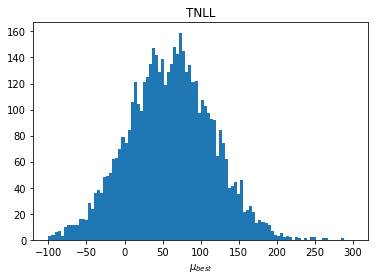

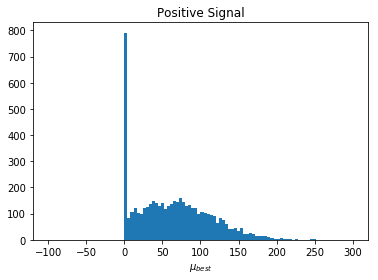

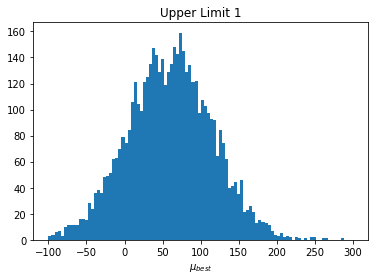

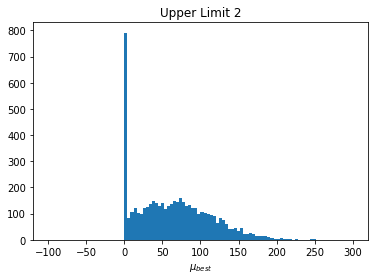

In [10]:
plt.hist(mu_best_TNLL, bins=np.linspace(-100, 300, 101))
plt.title("TNLL")
plt.xlabel(r"$\mu_{best}$")
plt.show()

plt.hist(mu_best_PosSig, bins=np.linspace(-100, 300, 101))
plt.title("Positive Signal")
plt.xlabel(r"$\mu_{best}$")
plt.show()

plt.hist(mu_best_UppLim1, bins=np.linspace(-100, 300, 101))
plt.title("Upper Limit 1")
plt.xlabel(r"$\mu_{best}$")
plt.show()

plt.hist(mu_best_UppLim2, bins=np.linspace(-100, 300, 101))
plt.title("Upper Limit 2")
plt.xlabel(r"$\mu_{best}$")
plt.show()

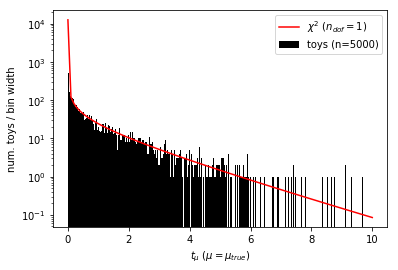

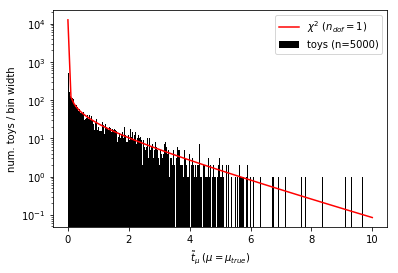

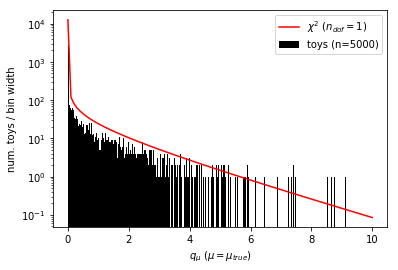

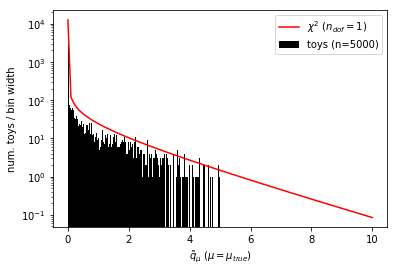

In [11]:
xp = np.linspace(0.00001,10,101)
plt.plot(xp, len(toys)*stats.chi2.pdf(xp, 1)/50., "-", color="red", label="$\chi^2$ ($n_{dof}=1$)")
plt.hist(q_TNLL, bins=np.linspace(0,10,501), color="black", label=f"toys (n={len(toys)})")
plt.gca().set_yscale("log")
plt.legend(loc="upper right")
plt.ylabel("num. toys / bin width")
plt.xlabel("$t_\mu$ ($\mu=\mu_{true}$)")
plt.show()

plt.plot(xp, len(toys)*stats.chi2.pdf(xp, 1)/50., "-", color="red", label="$\chi^2$ ($n_{dof}=1$)")
plt.hist(q_PosSig, bins=np.linspace(0,10,501), color="black", label=f"toys (n={len(toys)})")
plt.gca().set_yscale("log")
plt.legend(loc="upper right")
plt.ylabel("num. toys / bin width")
plt.xlabel(r"$\tilde t_\mu$ ($\mu=\mu_{true}$)")
plt.show()

plt.plot(xp, len(toys)*stats.chi2.pdf(xp, 1)/50., "-", color="red", label="$\chi^2$ ($n_{dof}=1$)")
plt.hist(q_UppLim1, bins=np.linspace(0,10,501), color="black", label=f"toys (n={len(toys)})")
plt.gca().set_yscale("log")
plt.legend(loc="upper right")
plt.ylabel("num. toys / bin width")
plt.xlabel(r"$q_\mu$ ($\mu=\mu_{true}$)")
plt.show()

plt.plot(xp, len(toys)*stats.chi2.pdf(xp, 1)/50., "-", color="red", label="$\chi^2$ ($n_{dof}=1$)")
plt.hist(q_UppLim2, bins=np.linspace(0,10,501), color="black", label=f"toys (n={len(toys)})")
plt.gca().set_yscale("log")
plt.legend(loc="upper right")
plt.ylabel("num. toys / bin width")
plt.xlabel(r"$\tilde q_\mu$ ($\mu=\mu_{true}$)")
plt.show()

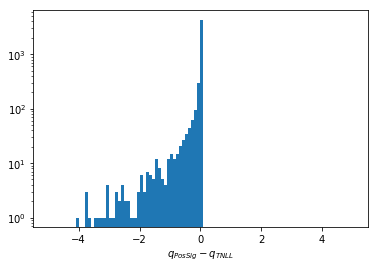

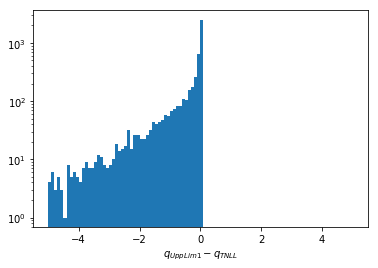

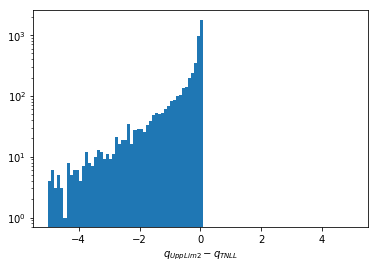

In [12]:
plt.hist([a-b for a, b in zip(q_PosSig, q_TNLL)], bins=np.linspace(-5, 5, 101))
plt.xlabel(r"$q_{PosSig} - q_{TNLL}$")
plt.gca().set_yscale("log")
plt.show()

plt.hist([a-b for a, b in zip(q_UppLim1, q_TNLL)], bins=np.linspace(-5, 5, 101))
plt.xlabel(r"$q_{UppLim1} - q_{TNLL}$")
plt.gca().set_yscale("log")
plt.show()

plt.hist([a-b for a, b in zip(q_UppLim2, q_TNLL)], bins=np.linspace(-5, 5, 101))
plt.xlabel(r"$q_{UppLim2} - q_{TNLL}$")
plt.gca().set_yscale("log")
plt.show()

In [13]:
mu = np.linspace(0, 300, 16)
toy_q_TNLL, toy_q_PosSig, toy_q_UppLim1, toy_q_UppLim2 = {}, {}, {}, {}
toys_per_mu = 1000

for m in mu :
    print(f"Running for mu = {m}")
    toys_m = model.generate_toys(toys_per_mu, s=m)
    toy_q_TNLL    [m] = []
    toy_q_PosSig  [m] = []
    toy_q_UppLim1 [m] = []
    toy_q_UppLim2 [m] = []
    for toy in toys_m :
        toy_q_TNLL   [m].append(TestStat_TNLL          (toy).evaluate(m))
        toy_q_PosSig [m].append(TestStat_PositiveSignal(toy).evaluate(m))
        toy_q_UppLim1[m].append(TestStat_UpperLimit1   (toy).evaluate(m))
        toy_q_UppLim2[m].append(TestStat_UpperLimit2   (toy).evaluate(m))
    toy_q_TNLL    [m].sort()
    toy_q_PosSig  [m].sort()
    toy_q_UppLim1 [m].sort()
    toy_q_UppLim2 [m].sort()
    


Running for mu = 0.0
Running for mu = 20.0
Running for mu = 40.0
Running for mu = 60.0
Running for mu = 80.0
Running for mu = 100.0
Running for mu = 120.0
Running for mu = 140.0
Running for mu = 160.0
Running for mu = 180.0
Running for mu = 200.0
Running for mu = 220.0
Running for mu = 240.0
Running for mu = 260.0
Running for mu = 280.0
Running for mu = 300.0


In [14]:
save_to_pickle("toy_q_TNLL.pickle"   , toy_q_TNLL   , toys_per_mu=toys_per_mu)
save_to_pickle("toy_q_PosSig.pickle" , toy_q_PosSig , toys_per_mu=toys_per_mu)
save_to_pickle("toy_q_UppLim1.pickle", toy_q_UppLim1, toys_per_mu=toys_per_mu)
save_to_pickle("toy_q_UppLim2.pickle", toy_q_UppLim2, toys_per_mu=toys_per_mu)

In [15]:
def get_p_val (q, q_sorted_list) :
    x = np.linspace(0, 1, len(q_sorted_list))
    p = np.interp([q], q_sorted_list, x)[0]
    if p < 0 : p = 0
    if p > 1 : p = 1
    return 1.0 - p

In [16]:
mu     = np.linspace(0, 300, 16)
n_pass_TNLL_as = np.zeros(shape=(len(mu),))
n_pass_TNLL    = np.zeros(shape=(len(mu),))
n_pass_PosSig  = np.zeros(shape=(len(mu),))
n_pass_UppLim1 = np.zeros(shape=(len(mu),))
n_pass_UppLim2 = np.zeros(shape=(len(mu),))

max_toy = 1000
CL = .95
for idx_toy, toy in enumerate(toys[:max_toy]) :
    if (1+idx_toy)*10 % max_toy == 0 :
        print(f"{100*(1+idx_toy)/max_toy:.0f}% complete")
    test_stat_TNLL    = TestStat_TNLL(toy)
    test_stat_PosSig  = TestStat_PositiveSignal(toy)
    test_stat_UppLim1 = TestStat_UpperLimit1(toy)
    test_stat_UppLim2 = TestStat_UpperLimit2(toy)
    for idx, m in enumerate(mu) :
        q_mu_TNLL    = test_stat_TNLL   .evaluate(m)
        q_mu_PosSig  = test_stat_PosSig .evaluate(m)
        q_mu_UppLim1 = test_stat_UppLim1.evaluate(m)
        q_mu_UppLim2 = test_stat_UppLim2.evaluate(m)
        p_val_TNLL    = get_p_val(q_mu_TNLL   , toy_q_TNLL[m])
        p_val_TNLL_as = 1.0 - stats.chi2.cdf(q_mu_TNLL, 1)
        p_val_PosSig  = get_p_val(q_mu_PosSig , toy_q_PosSig[m])
        p_val_UppLim1 = get_p_val(q_mu_UppLim1, toy_q_UppLim1[m])
        p_val_UppLim2 = get_p_val(q_mu_UppLim2, toy_q_UppLim2[m])
        if p_val_TNLL    > 1.0 - CL : n_pass_TNLL   [idx] = n_pass_TNLL   [idx] + 1
        if p_val_TNLL_as > 1.0 - CL : n_pass_TNLL_as[idx] = n_pass_TNLL_as[idx] + 1
        if p_val_PosSig  > 1.0 - CL : n_pass_PosSig [idx] = n_pass_PosSig [idx] + 1
        if p_val_UppLim1 > 1.0 - CL : n_pass_UppLim1[idx] = n_pass_UppLim1[idx] + 1
        if p_val_UppLim2 > 1.0 - CL : n_pass_UppLim2[idx] = n_pass_UppLim2[idx] + 1
    

10% complete
20% complete
30% complete
40% complete
50% complete
60% complete
70% complete
80% complete
90% complete
100% complete


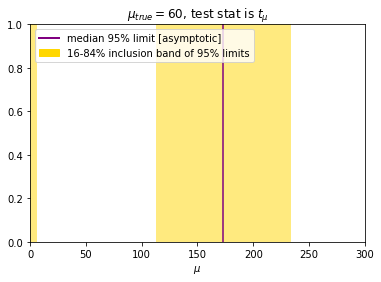

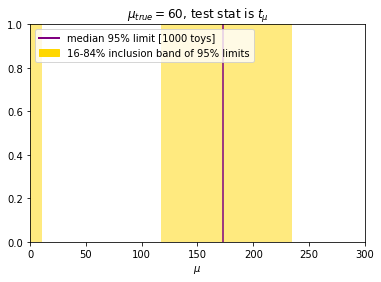

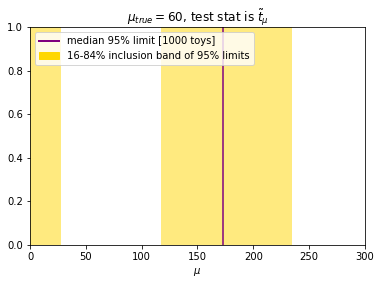

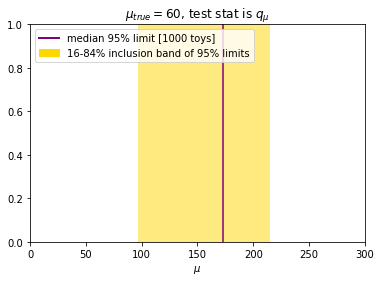

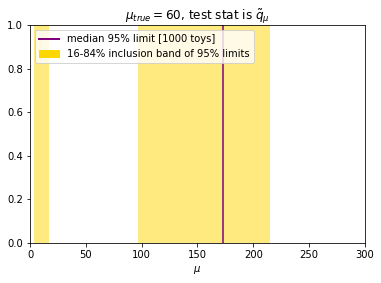

In [17]:
plot_y = [0, 1]
plot_x, plot_y = np.meshgrid(mu, plot_y)

plot_z_TNLL    = np.array([n_pass_TNLL, n_pass_TNLL]) / max_toy
plot_z_TNLL_as = np.array([n_pass_TNLL_as, n_pass_TNLL_as]) / max_toy
plot_z_PosSig  = np.array([n_pass_PosSig , n_pass_PosSig ]) / max_toy
plot_z_UppLim1 = np.array([n_pass_UppLim1, n_pass_UppLim1]) / max_toy
plot_z_UppLim2 = np.array([n_pass_UppLim2, n_pass_UppLim2]) / max_toy

plt.contour (plot_x, plot_y, plot_z_TNLL_as, [0.5], colors="purple")
plt.contourf(plot_x, plot_y, plot_z_TNLL_as, [0.16, 0.84], colors="gold", alpha=0.5)
plt.legend([Line2D([0], [0], color="purple"  , lw=2),
            Patch (          color="gold"    , linestyle=None)],
           [f"median 95% limit [asymptotic]",
            f"16-84% inclusion band of 95% limits"],
            loc="upper left")
plt.xlabel("$\mu$")
plt.title("$\mu_{true} = "+f"{model.n_sig:.0f}$"+", test stat is $t_\mu$")
plt.show()

plt.contour (plot_x, plot_y, plot_z_TNLL, [0.5], colors="purple")
plt.contourf(plot_x, plot_y, plot_z_TNLL, [0.16, 0.84], colors="gold", alpha=0.5)
plt.legend([Line2D([0], [0], color="purple"  , lw=2),
            Patch (          color="gold"    , linestyle=None)],
           [f"median 95% limit [{max_toy:.0f} toys]",
            f"16-84% inclusion band of 95% limits"],
            loc="upper left")
plt.xlabel("$\mu$")
plt.title("$\mu_{true} = "+f"{model.n_sig:.0f}$"+", test stat is $t_\mu$")
plt.show()

plt.contour (plot_x, plot_y, plot_z_TNLL, [0.5], colors="purple")
plt.contourf(plot_x, plot_y, plot_z_PosSig, [0.16, 0.84], colors="gold", alpha=0.5)
plt.legend([Line2D([0], [0], color="purple"  , lw=2),
            Patch (          color="gold"    , linestyle=None)],
           [f"median 95% limit [{max_toy:.0f} toys]",
            f"16-84% inclusion band of 95% limits"],
            loc="upper left")
plt.xlabel("$\mu$")
plt.title("$\mu_{true} = "+f"{model.n_sig:.0f}$"+r", test stat is $\tilde t_\mu$")
plt.show()

plt.contour (plot_x, plot_y, plot_z_TNLL, [0.5], colors="purple")
plt.contourf(plot_x, plot_y, plot_z_UppLim1, [0.16, 0.84], colors="gold", alpha=0.5)
plt.legend([Line2D([0], [0], color="purple"  , lw=2),
            Patch (          color="gold"    , linestyle=None)],
           [f"median 95% limit [{max_toy:.0f} toys]",
            f"16-84% inclusion band of 95% limits"],
            loc="upper left")
plt.xlabel("$\mu$")
plt.title("$\mu_{true} = "+f"{model.n_sig:.0f}$"+r", test stat is $q_\mu$")
plt.show()

plt.contour (plot_x, plot_y, plot_z_TNLL, [0.5], colors="purple")
plt.contourf(plot_x, plot_y, plot_z_UppLim2, [0.16, 0.84], colors="gold", alpha=0.5)
plt.legend([Line2D([0], [0], color="purple"  , lw=2),
            Patch (          color="gold"    , linestyle=None)],
           [f"median 95% limit [{max_toy:.0f} toys]",
            f"16-84% inclusion band of 95% limits"],
            loc="upper left")
plt.xlabel("$\mu$")
plt.title("$\mu_{true} = "+f"{model.n_sig:.0f}$"+r", test stat is $\tilde q_\mu$")
plt.show()

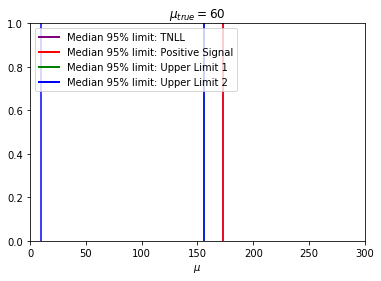

In [18]:
plt.contour (plot_x, plot_y, plot_z_TNLL   , [0.5], colors="purple")
plt.contour (plot_x, plot_y, plot_z_PosSig , [0.5], colors="red"   )
plt.contour (plot_x, plot_y, plot_z_UppLim1, [0.5], colors="green" )
plt.contour (plot_x, plot_y, plot_z_UppLim2, [0.5], colors="blue"  )
plt.legend([Line2D([0], [0], color="purple", lw=2),
            Line2D([0], [0], color="red"   , lw=2),
            Line2D([0], [0], color="green" , lw=2),
            Line2D([0], [0], color="blue"  , lw=2)],
           ["Median 95% limit: TNLL",
            "Median 95% limit: Positive Signal",
            "Median 95% limit: Upper Limit 1",
            "Median 95% limit: Upper Limit 2"],
            loc="upper left")
plt.xlabel("$\mu$")
plt.title("$\mu_{true} = "+f"{model.n_sig:.0f}$")
plt.show()

In [ ]:
[a-b for a, b in zip(n_pass_PosSig, n_pass_TNLL)]

In [ ]:
[a-b for a, b in zip(n_pass_UppLim1, n_pass_TNLL)]

In [ ]:
[a-b for a, b in zip(n_pass_UppLim2, n_pass_TNLL)]